# Topic Modeling Lab

- In this lab, we'll learn about topic modeling. Topic modeling uses statistics to understand what text is about, that is, to find the topics in text.
- We'll use the online dating profile text that OKCupid made public as our example, but of course topic modeling can be used on any text.
- (Some of the code for this lab was adapted from [Aneesha Bakharia](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730)'s example.)

# 0. Setup and cleaning
### Step 1: Import the packages we'll use

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage
from scipy.stats.stats import pearsonr  
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

### Step 2: Read in our data 

#### Important note: 
Before loading this data, you **must** run the code from section `0. Setup` in Lab `1. What is in a dating profile?`. This code prepares the data we'll be using.

In [2]:
profiles = pd.read_csv('data/clean_profiles.tsv', sep='\t')
profiles.head(2)

,age_group,age,body,alcohol_use,drug_use,edu,race_ethnicity,height_group,industry,kids,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,20,22,overweight,yes,no,HS,multiple,over_6,other,no,...,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...
1,30,35,average,yes,yes,unknown,White,under_6,other,no,...,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN


### Step 3: Pick which section of the profiles you want to analyze.
#### Options:
- text - All of the text from a profile
- essay0 - My self summary
- essay1 - What I’m doing with my life
- essay2 - I’m really good at
- essay3 - The first thing people usually notice about me
- essay4 - Favorite books, movies, show, music, and food
- essay5 - The six things I could never do without
- essay6 - I spend a lot of time thinking about
- essay7 - On a typical Friday night I am
- essay8 - The most private thing I am willing to admit
- essay9 - You should message me if...

#### Replace `'essay0'` in the cell below with the essay you want to look at.

In [3]:
profile_section_to_use = 'essay0'

### Step 4: Clean up the text for that essay.
#### Helper function for cleaning up text
- removes HTML code, link artifacts
- converts to lowercase

In [4]:
# Some of the essays have just a link in the text. BeautifulSoup sees that and gets 
# the wrong idea. This line hides those warnings.
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

def clean(text):
    if pd.isnull(text):
        t = np.nan
    else:
        t = BeautifulSoup(text, 'lxml').get_text()
        t = t.lower()

        bad_words = ['http', 'www', '\nnan']

        for b in bad_words:
            t = t.replace(b, '')
    if t == '':
        t = np.nan
    
    return t

#### Clean and select the text.

In [5]:
print('Cleaning up profile text for', profile_section_to_use, '...')
profiles['clean'] = profiles[profile_section_to_use].apply(clean)

print('We started with', profiles.shape[0], 'profiles.')
print("Dropping profiles that didn't write anything for the essay we chose...")
profiles.dropna(axis=0, subset=['clean'], inplace=True)

#what we will use as our documents, here the cleaned up text of each profile
documents = profiles['clean'].values

print('We have', profiles.shape[0], 'profiles left.')

Cleaning up profile text for essay0 ...
We started with 58785 profiles.
Dropping profiles that didn't write anything for the essay we chose...
We have 53396 profiles left.


# 1. Converting text to numbers for a topic model

### Step 1: Convert text to numbers the computer understands
- Our first model takes "count vectors" as input, that is, a count of how many times each word shows up in each document. 
    - Here we tell it to only use the 1,000 most popular words, ignoring stop words like "a" and "of".
    - We use the abbreviation `tf` for these because they represent "text frequency," i.e., how often each word shows up in text.

In [6]:
tf_vectorizer = CountVectorizer(max_features=1000, stop_words='english')

print("Vectorizing text by word counts...")
tf_text = tf_vectorizer.fit_transform(documents)

tmp = tf_text.get_shape()
print("Our transformed text has", tmp[0], "rows and", tmp[1], "columns.")

Vectorizing text by word counts...
Our transformed text has 53396 rows and 1000 columns.


#### See what words are being counted

In [7]:
tf_feature_names = tf_vectorizer.get_feature_names()

print("The first few words (alphabetically) are:\n", tf_feature_names[:20])

The first few words (alphabetically) are:
 ['10', '11', '12', '15', '20', '30', 'ability', 'able', 'abroad', 'absolutely', 'act', 'active', 'activities', 'activity', 'actually', 'add', 'admit', 'adventure', 'adventures', 'adventurous']


#### See an example of how a profile's text is encoded
- Change the value of `n` and re-run the code to see different profiles.
- Note that only some of the words are counted. This is because we set `max_features=1000` in the vectorizor function, so it is only counting the 1,000 most common words and ignoring the rest. 
    - You can change that number to be bigger or smaller and see what happens.
    - We found in Lab 1 that 1,000 is a good choice for this data because words less popular than that show up in less than 1% of all profiles.

In [8]:
n = 6

def show_vector(x):
    rows,cols = x.nonzero()
    for row,col in zip(rows,cols):
        print(tf_feature_names[col], x[row,col])

print('Profile text:\n', documents[n])
print('\nTF (count) vector:')
show_vector(tf_text[n])

Profile text:
 life is about the little things. i love to laugh. it's easy to do
when one can find beauty and humor in the ugly. this perspective
makes for a more gratifying life. it's a gift. we are here to play.

TF (count) vector:
play 1
humor 1
beauty 1
easy 1
makes 1
laugh 1
little 1
life 2
things 1
love 1


# 2. Build a topic model using LDA

- LDA stands for Latent Dirichlet Allocation. The statistical math behind it is complicated, but its goals are simple:
    - find groups of words that often show up together and call those groups topics. 
    - find topics that can be used to tell documents apart, i.e. topics that are in some documents but not others.
- LDA is the most popular method for topic modeling.
- [Learn more](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) about LDA

### Step 1: Decide how many topics we want to find
- We must tell LDA how many topics we want it to look for (we did this above with the `ntopics` variable.

In [9]:
#how many topics we want our model to find
ntopics = 15

#how many top words we want to display for each topic
nshow = 10

### Step 2: Run the LDA algorithm
- LDA can be a little slow. We'll use a faster method later on.
- Set `n_jobs=` to the number of processors you want to use to compute LDA. If you set it to `-1`, it will use all available processors. 

In [10]:
model = LatentDirichletAllocation(n_components=ntopics, max_iter=10, 
                                  learning_method='online', n_jobs=-1)

print('Performing LDA on vectors...')
lda = model.fit(tf_text)
lda_topics = lda.components_

print('Done!')

Performing LDA on vectors...
Done!


# 3. Interpret the topics the model gives us
#### Some helper functions 
Don't worry about how these work right now. We'll use them to make our analysis easier later on.

In [11]:
def describe_topic(topic, feature_names, n_words=10):
    words = []
    # sort the words in the topic by importance
    topic = topic.argsort() 
    # select the n_words most important words
    topic = topic[:-n_words - 1:-1]
    # for each important word, get it's name (i.e. the word) from our list of names
    for i in topic:
        words.append(feature_names[i])
    # print the topic number and its most important words, separated by spaces
    return " ".join(words)

def display_topics(components, feature_names, n_words=10):
    # loop through each topic (component) in the model; show its top words
    for topic_idx, topic in enumerate(components):
        print("Topic {}:".format(topic_idx), 
              describe_topic(topic, feature_names, n_words))
    return

def find_intersection(idxa, idxb, n):
    a = set()
    b = set()
    both = set()
    i = 0
    while len(both) < n:
        a.add(idxa[i])
        b.add(idxb[i])
        both = a.intersection(b)
        i += 1
    return list(both)

def compare_topic_words(topics, a, b, words, how='overlap', n_words=nshow):
    b_sort = False
    if how == 'difference':
        b_sort = True
    
    dfa = pd.DataFrame(topics, columns=words).T
    idxa = dfa.sort_values(by=a, ascending=False).index.values
    idxb = dfa.sort_values(by=b, ascending=b_sort).index.values
    both = find_intersection(idxa, idxb, n=n_words)
    
    out = how + ' between ' + str(a) + ' and ' + str(b) + ':'
    for w in both:
        out += ' ' + w
    print(out)
    return

def blue_matrix(cells, x_labels=None):
    n = cells.shape[0]
    plt.figure()
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(cells, cmap='Blues')
    ax.xaxis.tick_top()
    if x_labels is not None:
        plt.xticks(range(n), x_labels)
    else:
        plt.xticks(range(n))
    plt.yticks(range(n))
    # show a colorbar legend
    plt.colorbar()
    return

def plot_topics(components):
    n = components.shape[0]
    # sort topics into similar groups
    blue_matrix(cosine_similarity(components))
    return

### Step 1: Show our topics with the top words in each

In [12]:
display_topics(lda_topics, tf_feature_names, n_words=nshow)

Topic 0: love like enjoy music new good things friends time people
Topic 1: looking life good friends love open fun person relationship honest
Topic 2: hiking hanging experiences road trips trip camping biking weekend outdoors
Topic 3: humor sense nerd art science music interests sarcastic middle politics
Topic 4: life love things people world live make try believe want
Topic 5: like don think ve really pretty just little know say
Topic 6: east coast school college york west com went decided california
Topic 7: just people know like want don really new meet things
Topic 8: man woman love life lover heart loves dogs confident loving
Topic 9: love day ve world art good work music dance life
Topic 10: self rock summary change work okcupid wrong climbing ass shit
Topic 11: im hi student chill dont just cats school lets deeply
Topic 12: bay years area new ve love moved sf lived time
Topic 13: going easy fun games guy outgoing pretty hard play video
Topic 14: san francisco city moved living 

### Step 2: Examine the words that make two topics similar or different
- We can also compare two topics to each other by looking at words that are common in both, or words that are common in one but not the other.
- Try changing `topic_a` and `topic_b` to different topic numbers.
- Notice the `how` option will let you see either the `overlap` or `difference` between two topics
    - Notice also that the difference between topics a and b is not the same as between b and a

In [13]:
topic_a = 0
topic_b = 2

compare_topic_words(lda_topics, topic_a, topic_b, tf_feature_names, how='overlap', n_words=nshow)
compare_topic_words(lda_topics, topic_a, topic_b, tf_feature_names, how='difference', n_words=nshow)
compare_topic_words(lda_topics, topic_b, topic_a, tf_feature_names, how='difference', n_words=nshow)

overlap between 0 and 2: outdoors exploring dancing new beach travel traveling cooking hiking friends
difference between 0 and 2: giants sleep drink play baseball watch watching tv football listen
difference between 2 and 0: salsa trip japan trips road hip lake experiences hop weekend


### Step 3: Interpret these topics
- This part is for you to do: code can't do it for you.
- Look at the list of important words for each topic, and think about these questions.
    - What do the words have in common?
    - What could someone write that would use most of those words?
    - What does this topic seem to be about?
- Try to come up with a short, catchy name for each topic.
    - For example, if the words were "san francisco city moved living born years raised lived live", you might call it "places lived" because the topic seems to be about where people currently live (San Francisco) and where they were born / raised / moved from. 
- Try other numbers of topics.
    - If the topics seem repetitive, you might want to try looking for fewer topics.
    - If the topics seem confusing or vague, you might want to try looking for more topics (so that they can be more specific).
    
### Step 4: Check whether your interpretations match with the text

#### Helper function

In [14]:
def get_profiles_from_topics(data, transformed, topic_a, topic_b=None, pick_from=10):
    df = pd.DataFrame(transformed)
    df = df.sort_values(by=topic_a, ascending=False)
    match_text = ''
    
    if topic_b is None:
        keep = df.head(pick_from).sample(1)
        pid = keep.index.values[0]
    else:
        idxb = df.sort_values(by=topic_b, ascending=False).index.values
        both = find_intersection(df.index.values, idxb, pick_from)
        keep = df.loc[both, :].sample(1)
        pid = keep.index.values[0]        
        
    match_text = 'Profile number ' + str(pid)
    match_text += ' is the number ' + str(np.where(df.index==pid)[0][0])
    match_text += ' profile for topic ' + str(topic_a)
    if topic_b is not None:
        match_text += ' and the number ' + str(np.where(idxb==pid)[0][0])
        match_text += ' profile for topic ' + str(topic_b)
        
    text = data[pid]
    print(match_text)
    print('Here is the text:\n\n', text)
    return


def visualize_profile(profile_topics, profile_id):
    # plot a stem diagram for a single profile
    plt.figure(figsize=(8,4))
    plt.xticks(range(profile_topics.shape[1]))
    plt.xlabel('Topic number')
    plt.ylabel('How much of profile is about each topic')
    plt.title('Profile #'+str(profile_id))
    plt.stem(profile_topics[profile_id,:])
    return

#### Figure out how much of each topic is in each profile

In [15]:
profile_topics = lda.transform(tf_text)

#### Look at the text of a profile that has a lot of a particular topic
- This function randomly picks one of the top few profiles for a topic, so each time you run it you will see a different example.
    - If you want it to pick from more or less topics, change the value of `pick_from`
    - If you want to see a different topic, change the value of `topic_a`
    - **Hint:** you can press `ctrl`+`enter` over and over to keep re-running the code in this cell.

In [16]:
get_profiles_from_topics(documents, profile_topics, topic_a=0, pick_from=20)

Profile number 34756 is the number 4 profile for topic 0
Here is the text:

 i like to be active, have fun, and laugh a lot.
i like to enjoy the little things in life.
i wish drinking beers while being at a concert in a park was a
legit occupation.
i like to surround myself with good people.
i am always up for trying something new.


#### Look at the text of a profile that matches two topics well at the same time
- Note that some topics might not happen together very often. If this is the case, the examples we find of both together might not be very good.

In [17]:
get_profiles_from_topics(documents, profile_topics, topic_a=0, topic_b=2)

Profile number 48886 is the number 758 profile for topic 0 and the number 736 profile for topic 2
Here is the text:

 i love to skateboard. i listen to punk, metal, classic rock, goth,
dub step, and under ground hip-hop. i really love music. i base my
hole life around it. right now i'm trying to get my g.e.d


#### See how much of a profile is about each topic
- Try looking at some of the profiles you just found:
    - Make the `pid` equal to the profile number from above.

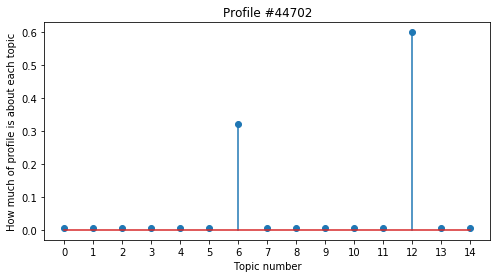

In [18]:
pid = 44702
visualize_profile(profile_topics, profile_id=pid)

# 4. Quality of topics

### Step 1: See how similar the words in each topic are to the words in other topics
We can compare topics visually by plotting the similarity of each topic to each other topic. How to interpret:
- Each square shows how similar two topics are. Darker means more similar, and lighter means more different.
- The square in the very top right shows how similar topic 0 is to topic 0 (i.e. how similar it is to itself). 
- The square next to it in the top row shows how similar topic 0 is to topic 1, and so on. 
- For any two topics, you can see how similar they are by finding their numbers on the edge and seeing where they intersect.

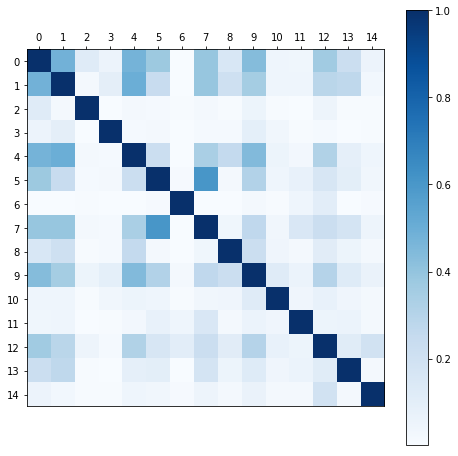

In [19]:
plot_topics(lda_topics)

### Step 2: See how often topics show up together in the same profiles

- This shows us something that looks similar to the topic similarity we saw before, but this time:
    - We don't compare topics based on which words they use
    - We do compare topics based on how often they appear in the same profile as one another
- Why is the diagonal line so dark?

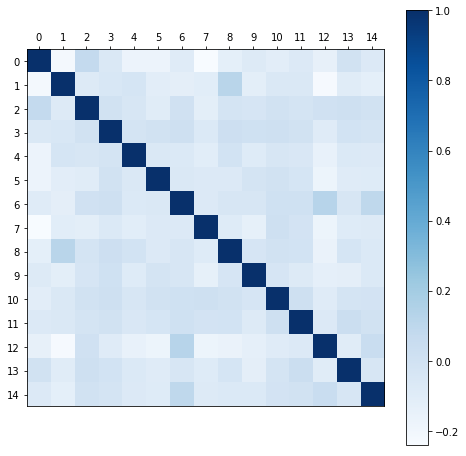

In [20]:
def topic_cooccurance(topics):
    n = topics.shape[1]
    m = pd.DataFrame(topics).corr()
    blue_matrix(m)

topic_cooccurance(profile_topics)

#### Note that the topics are mostly uncorrelated. 
- The cells in the figure above are mostly very light blue
- This doesn't mean that, for instance, topic 1 and 2 never show up in the same profile.
- It does mean, however, that seeing any particular topic doesn't mean we're especially likely to also see any other topic.

#### Just because they're uncorrelated doesn't mean there isn't a pattern in the relationship between two topics
- This makes a scatterplot where each dot is a profile
- The dot's X and Y position show how much of a profile is about each topic
- Try different topic combinations.
- Do the profiles cluster into distinct groups?
- What might these groups mean?

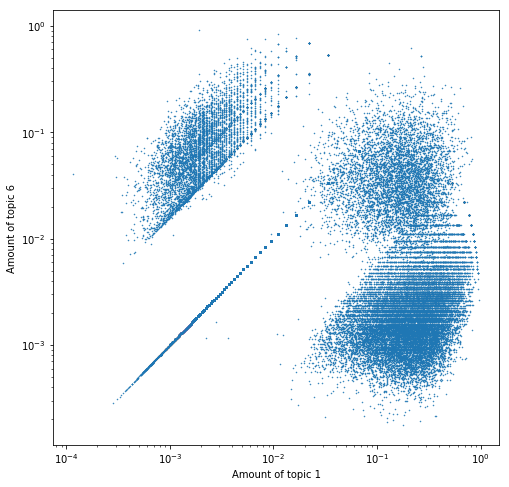

In [21]:
def profile_scatter(profile_topics, topic_x_id, topic_y_id):
    # create a scatter plot of profiles with each axis representing one topic
    plt.figure(figsize=(8,8))
    plt.loglog(profile_topics[:,topic_x_id], profile_topics[:,topic_y_id], '.', markersize=1)
    plt.xlabel('Amount of topic {}'.format(topic_x_id))
    plt.ylabel('Amount of topic {}'.format(topic_y_id))

profile_scatter(profile_topics, topic_x_id=1, topic_y_id=6)

# 5. Topic popularity

#### Helper functions to visualize and compare topics


In [64]:
def common_topics_bars(topics):
    popularity = pd.DataFrame(topics).mean()
    popularity = popularity.rename_axis('Topic')
    popularity = popularity.sort_values(ascending=False)
    popularity.plot.bar(title='Topic popularity')
    return

def rank_groups(data, trait, topic):
    groups = data[trait].value_counts().index.values
    result = {}
    
    for g in groups:
        result[g] = data[data[trait] == g][topic].mean()
    
    r = pd.DataFrame.from_dict(result, orient='index')
    r.columns = [topic]
    r = r.sort_values(by=topic, ascending=False)
    
    return r.round(3)

def top_topics(data, trait, value, n_top_topics=3, distinctive=False):
    topics = [col for col in data if col.startswith('topic_')]
    vals = {}
    means = {}
    if distinctive:
        for t in topics:
            means[t] = data[t].mean()
    else:
        for t in topics:
            means[t] = 1
    
    data = data[data[trait] == value]
    
    for t in topics:
        vals[t] = data[t].mean() / means[t]
    vals = pd.DataFrame.from_dict(vals, orient='index')
    vals = vals.sort_values(by=0, ascending=False).head(n_top_topics)
    
    return list(vals.index.values)

### Overall most common topics

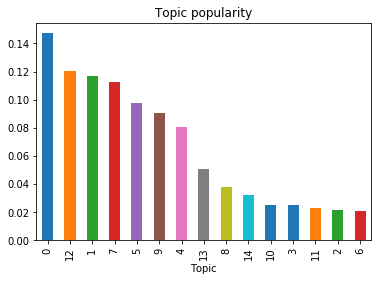

In [65]:
common_topics_bars(profile_topics)

### Who is a topic most popular with?

#### Step 1: Merge our information about topics with our information about people

In [66]:
topic_info = pd.DataFrame(profile_topics).add_prefix('topic_')
together = profiles.merge(topic_info, left_index=True, right_index=True)
together.head()

,age_group,age,body,alcohol_use,drug_use,edu,race_ethnicity,height_group,industry,kids,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,20,22,overweight,yes,no,HS,multiple,over_6,other,no,...,0.155453,0.015094,0.176478,0.000926,0.436088,0.000926,0.000926,0.000926,0.039942,0.000926
1,30,35,average,yes,yes,unknown,White,under_6,other,no,...,0.264845,0.001852,0.001852,0.036129,0.070126,0.001852,0.001852,0.001852,0.139624,0.001852
2,30,38,thin,yes,yes,Grad_Pro,NaN,under_6,NaN,no,...,0.409528,0.000980,0.323263,0.000980,0.000980,0.000980,0.000980,0.000980,0.000980,0.056412
3,20,23,thin,yes,yes,HS,White,under_6,education,no,...,0.022222,0.355555,0.022222,0.022222,0.022222,0.355555,0.022222,0.022222,0.022222,0.022222
4,20,29,fit,yes,no,BA,multiple,under_6,creative,no,...,0.003704,0.003704,0.948148,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704


#### Step 2: See the groups that have the most text about a given topic
- The numbers here show how much of a profile, on average, is about a specific topic.
- Try different topics.
- Try different traits. Here are the options / information we know about users from their profiles
    - 'age_group', 
    - 'age', 
    - 'body', 
    - 'alcohol_use', 
    - 'drug_use',
    - 'edu', 
    - 'race_ethnicity', 
    - 'height_group', 
    - 'industry', 
    - 'kids', 
    - 'orientation', 
    - 'pets_likes', 
    - 'pets_has', 
    - 'pets_any', 
    - 'religion', 
    - 'sex', 
    - 'smoker', 
    - 'languages'

In [70]:
rank_groups(together, trait='edu', topic='topic_12')

,topic_12
BA,0.121
HS,0.121
Grad_Pro,0.120
unknown,0.120
<HS,0.108


#### Step 3: See the topics that take up the most text for a given group
- This example shows top topics for different education levels.
- You can change the arguments to compare different groups

In [60]:
#show most popular topics for High School graduates
top_topics(data=together, trait='edu', value='HS', n_top_topics=3)

['topic_0', 'topic_12', 'topic_1']

In [61]:
#show most popular topics for High School graduates
top_topics(data=together, trait='edu', value='Grad_pro', n_top_topics=3)

['topic_0', 'topic_1', 'topic_2']

#### Step 4: See the topics that distinguish a group from other groups
- This example shows top topics for different education levels.
- You can change the arguments to compare different groups

In [71]:
top_topics(data=together, trait='edu', value='HS', n_top_topics=3, distinctive=True)

['topic_3', 'topic_10', 'topic_6']

In [72]:
top_topics(data=together, trait='edu', value='Grad_pro', n_top_topics=3, distinctive=True)

['topic_0', 'topic_1', 'topic_2']

# NMF: an alternative to LDA
- NMF stands for Non-Negative Matrix Factorization. Just like you may have found factors in algebra class, this finds factors for the matrix of numbers representing word frequency in text. For example:
    - $ 10 $ can be factored as $ 2 * 5 $
    - $ x^2+3x+2 $ can be factored as $ (x+2)(x+1)$
- It turns out that finding factors for text is a really good way of finding topics. This makes sense intuitively: factors are simple things we can combine to get the more complicated output, and topics are simple things people combine to write profiles.
- [Learn more](https://en.wikipedia.org/wiki/Non-Negative_matrix_factorization#Text_mining) about NMF.


### Step 1: Convert text to numbers the computer understands
- NMF takes "tf-idf vectors" as input. Tf-idf stands for "text frequency - inverse document frequency." 
    - Text frequency is the same as the count vectors above: how often does each word appear in the text?
    - Inverse document frequency means we divide ("inverse") by the number of documents the word is in. (If everyone uses the word, it isn't very helpful for figuring out what makes people different. So this measurement looks for words that are used a lot in some documents, and not at all in others.)
    - Here we tell it to only use the 1,000 most popular words, ignoring stop words

In [74]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

print("Vectorizing text by TF-IDF...")
tfidf_text = tfidf_vectorizer.fit_transform(documents)

tmp = tfidf_text.get_shape()
print("Our transformed text has", tmp[0], "rows and", tmp[1], "columns.")

Vectorizing text by TF-IDF...
Our transformed text has 53396 rows and 1000 columns.


#### The features are mostly the same as count vectors, because they are just the common words in the text

In [75]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("The first few words (alphabetically) are:\n", tfidf_feature_names[:20])

The first few words (alphabetically) are:
 ['10', '11', '12', '15', '20', '30', 'ability', 'able', 'abroad', 'absolutely', 'act', 'active', 'activities', 'activity', 'actually', 'add', 'admit', 'adventure', 'adventures', 'adventurous']


#### The values are different: the counts have been divided by the documents they show up in

In [77]:
n = 1

print('Profile text:\n', documents[n])
print('\nTF (count) vector:')
show_vector(tfidf_text[n])

Profile text:
 i am a chef: this is what that means.
1. i am a workaholic.
2. i love to cook regardless of whether i am at work.
3. i love to drink and eat foods that are probably really bad for
me.
4. i love being around people that resemble line 1-3.
i love the outdoors and i am an avid skier. if its snowing i will
be in tahoe at the very least. i am a very confident and friendly.
i'm not interested in acting or being a typical guy. i have no time
or patience for rediculous acts of territorial pissing. overall i
am a very likable easygoing individual. i am very adventurous and
always looking forward to doing new things and hopefully sharing it
with the right person.

TF (count) vector:
love 0.295659472409
guy 0.131731440658
things 0.0951272785518
probably 0.15792201579
really 0.109328123882
work 0.110364122841
means 0.182495725919
cook 0.169153951551
drink 0.181278297239
eat 0.175058673315
foods 0.230007819672
bad 0.179099150725
people 0.0879759886981
line 0.210575210161
outdoors 0.1

### Step 2: Build a topic model using NMF

- NMF is faster than LDA and often works a little better for small documents like we have here.

In [79]:
model = NMF(n_components=ntopics, alpha=.1, l1_ratio=.5, init='nndsvd')

print('Performing NMF on vectors...')
nmf = model.fit(tfidf_text)
nmf_topics = nmf.components_

print('Done!')

Performing NMF on vectors...
Done!


### Step 3: Show our topics with the top words in each

In [80]:
display_topics(nmf_topics, tfidf_feature_names, nshow)

Topic 0: enjoy music movies hiking watching playing cooking friends reading sports
Topic 1: years sf moved ve ago school lived year coast city
Topic 2: don know really people think want ll say ve way
Topic 3: new people meet things meeting trying try places friends learning
Topic 4: like things play stuff feel watch lot think people movies
Topic 5: im dont lol chill thats guy know person laid nice
Topic 6: love laugh travel outdoors family dance cook make music food
Topic 7: life live world share things believe happy family living important
Topic 8: san francisco city born raised moved living diego live native
Topic 9: bay area raised born native east grew moved living lived
Topic 10: good humor sense food conversation pretty laugh company great friends
Topic 11: going easy person guy pretty laid earth fun open try
Topic 12: time work spend hard friends working lot family free play
Topic 13: just ask want know moved trying message wanna hang hey
Topic 14: looking fun guy loving meet ni

### Step 4: Compare topics to each other
We can compare topics visually by plotting the similarity of each topic to each other topic.

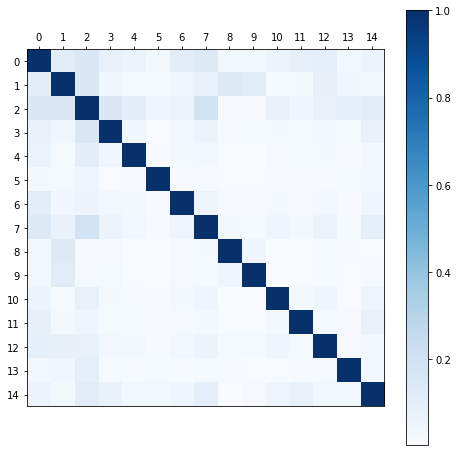

In [81]:
plot_topics(nmf_topics)

#### Examine the words that make two topics similar or different
We can also compare two topics to each other by looking at words that are common in both, or words that are common in one but not the other. Try changing topic_a and topic_b to different topic numbers.

In [84]:
topic_a = 1
topic_b = 8

compare_topic_words(nmf_topics, topic_a, topic_b, tfidf_feature_names, n_words=nshow, how='overlap')
compare_topic_words(nmf_topics, topic_a, topic_b, tfidf_feature_names, n_words=nshow, how='difference')
compare_topic_words(nmf_topics, topic_b, topic_a, tfidf_feature_names, n_words=nshow, how='difference')

overlap between 1 and 8: city years living originally recently lived grew born year moved
difference between 1 and 8: 10 outside oakland middle italy mountains places ny pretty played
difference between 8 and 1: clubs nice nerdy san reality relaxing hang male francisco friendly


### Step 5: Interpret these topics
- This part is for you to do: code can't do it for you.
- Look at the list of important words for each topic, and think about these questions.
    - What do the words have in common?
    - What could someone write that would use most of those words?
    - What does this topic seem to be about?
- Try to come up with a short, catchy name for each topic.
    - For example, if the words were "san francisco city moved living born years raised lived live", you might call it "places lived" because the topic seems to be about where people currently live (San Francisco) and where they were born / raised / moved from. 
- Try other numbers of topics.
    - If the topics seem repetitive, you might want to try looking for fewer topics.
    - If the topics seem confusing or vague, you might want to try looking for more topics (so that they can be more specific).

### Step 6: Compare the topics from LDA and NMF

#### Helper function to make a graph for us

In [86]:
def plot_confusion(x, y):
    n = x.shape[0]
    corrs = cosine_similarity(x, y)

    matches = []
    pairs = {}

    for i in range(n):
        for j in range(n):
            tmp = {}
            tmp['i'] = i
            tmp['j'] = j
            tmp['match'] = corrs[i][j]
            matches.append(tmp)

    matches = pd.DataFrame(matches).sort_values(by='match', ascending=False)

    for row in matches.iterrows():
        i = row[1]['i']
        j = row[1]['j']
        if i not in pairs.keys():
            if j not in pairs.values():
                pairs[i] = row[1]['j']

    new_order = np.zeros((n))
    for k in pairs.keys():
        new_order[int(k)] = int(pairs[k])

    topic_similarity = pd.DataFrame(corrs)
    topic_similarity = topic_similarity[new_order]

    blue_matrix(topic_similarity, new_order)

- We can compare the topics visually using a confusion matrix plot.
- The NMF topics are along the X axis and the LDA are along the Y axis.
- The NMF topics are sorted to match the closest LDA topic.

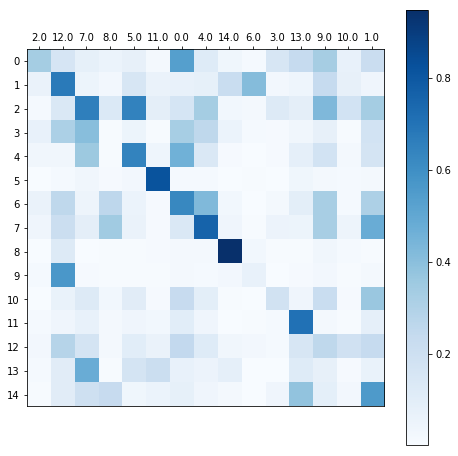

In [87]:
plot_confusion(x = nmf_topics, y = lda_topics)

By looking at the LDA and NMF topic words and the confusion matrix, consider the following questions:
- Do any of the topics seem to be the same in both models?
- Are some topics in one model but not the other?
- Do the topics you get from one of the models make more sense than the ones you get from the other?


# Reflection: What we've learned
- Two statistical methods for topic modeling
    - LDA
    - NMF
- Two ways to represent text as numbers
    - TF / count vectors (counts of how often each word is used)
    - TF-IDF vectors (counts of how often each word is used, divided by the number of documents they're used in)
- How to think about and interpret the topics our models find
- How to compare and relate different topics
- Different ways to see the distribution of topics in profiles
- Which topics are most popular with social categories of people
- Which social categories of people discuss a topic most